# *Tutorial: how to use Pado 🌊*

**Author:** Seung-Hwan Baek, Dong-Ha Shin | **Last Updated:** 2025-03-19

This jupyter notebook provides an introduction to `Pado`. Through this notebook, you will learn the basic building blocks of `Pado`: `light`, `optical element`, and `propagator`.

---

In your project folder, put the folder of pado like below
- YOUR PROJECT FOLDER
  - pado
    - light.py
    - optical_element.py
    - propagator.py
    - ...

In [1]:
cd ../..

c:\Users\yilin\pado


In [2]:
pwd

'c:\\Users\\yilin\\pado'

## 🌊 **Step 1: Import Pado**
First, you should import `Pado`. Make sure to install all the dependency :) 

In [3]:
import pado
from pado.math import nm, um
import torch
import matplotlib.pyplot as plt

## **💡Step 2: everything starts from light**

The fundamental element of `Pado` is `light`. As we want to simulate how `light` wave interacts with other `optical elements` and `propagate` in free space, we should start from defining `light`. Based on wave optics, we represent `light` wave as a 2D complex-valued field on a virtual plane. That is, each complex-valued element in the array represents the phase and ampiltude of `light` wave at that spatial location. 

We should first define the resolution of the `light` we want to simulate as

In [4]:
R = 1000  # number of rows
C = 1000  # number of columns
pitch = 2*um  # physical size of each pixel
wvl = 660*nm  # wavelength of the light
dim = (1, 1, R, C)  # dimension of the light [batch, channel, row, column]
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cpu


Then, we define the light. This can be easily done using the class `Light`. By default, it initializes the amplitude as one and the phase as zero, resulting in a planar wave. Note that we  store the data in GPU here, so we supply 'cuda:0' for the device argument. We can visualize the content of light with the `visualize()` function.

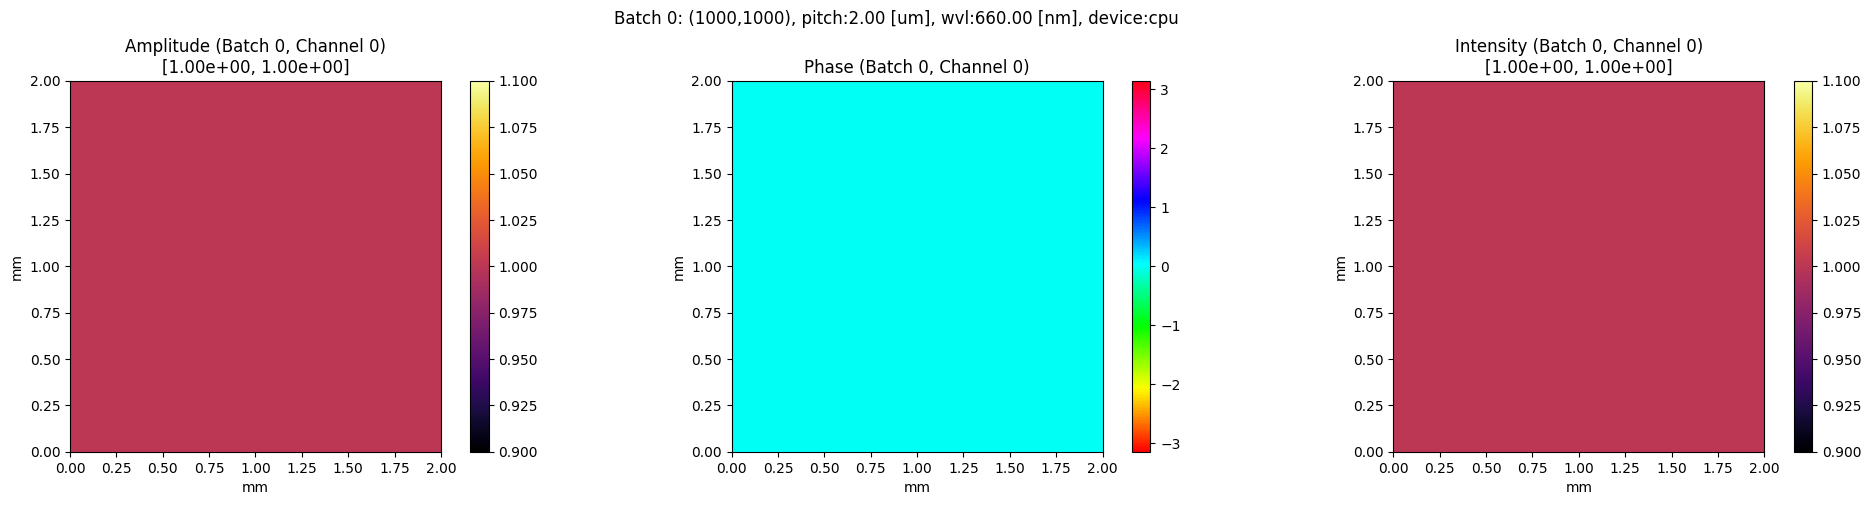

In [5]:
light = pado.light.Light(dim,pitch,wvl,device=device)
light.visualize()

## **🔭Step 3: build your own imaging/display system**
In this tutorial, we will use a simple camera with a `refractive lens` and an `aperture`. Note that we provide various `optical elements` that can interact with and transform `light` wave. Let's first define the basic `optical elements`: `lens` and `aperture`.

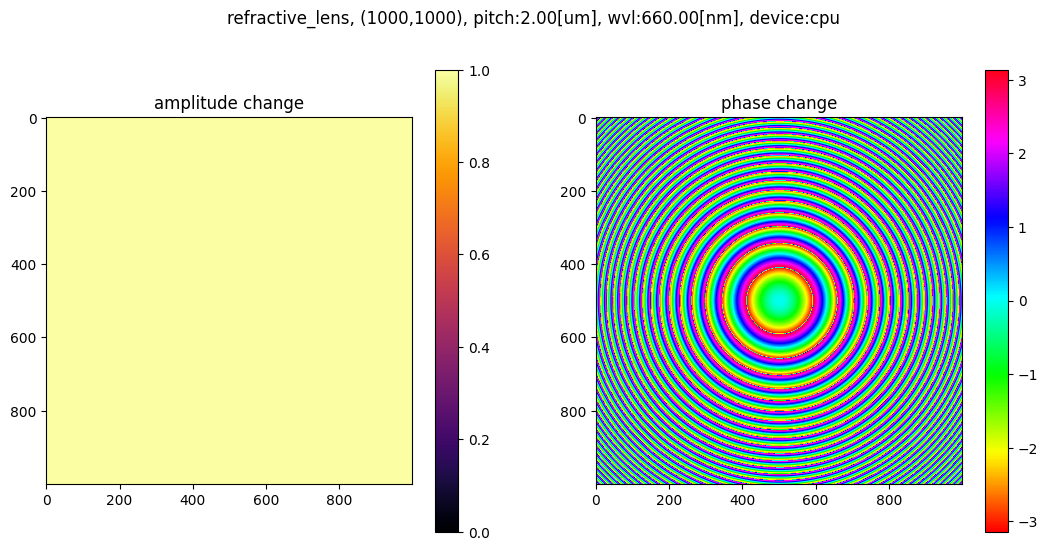

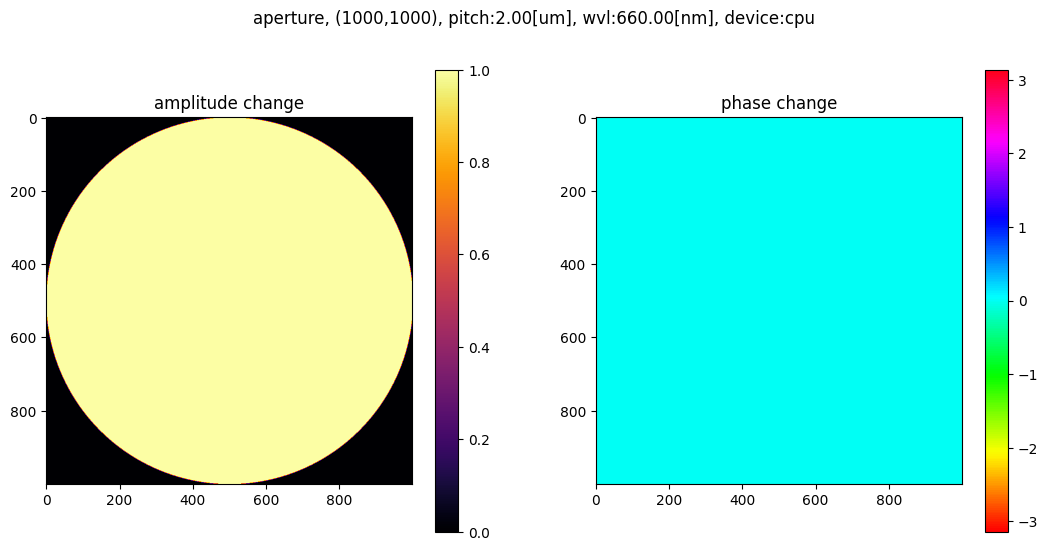

In [6]:
f = 50e-3  # focal length
lens = pado.optical_element.RefractiveLens(dim,pitch,f,wvl,device)
lens.visualize()

aperture = pado.optical_element.Aperture(dim, pitch, R*pitch, 'circle', wvl, device)
aperture.visualize()


Now, we want to simulate the point spread function (PSF) of this camera. In order to do this, we should use `light`, `lens`, `aperture`, and also `propagator`. The `propagator` computes how phase and amplitude of `light` changes after free-space propagation by a specific distance. Specifically, we use the `Angular Spectrum Method (ASM)` to calculate light propagation.

In [7]:
prop = pado.propagator.Propagator('ASM')

Let's combine everything together and simulate the system's PSF now. Key here is the function `forward` that takes the light and outputs the light after interaction with either the `optical element` or the `propagator`.

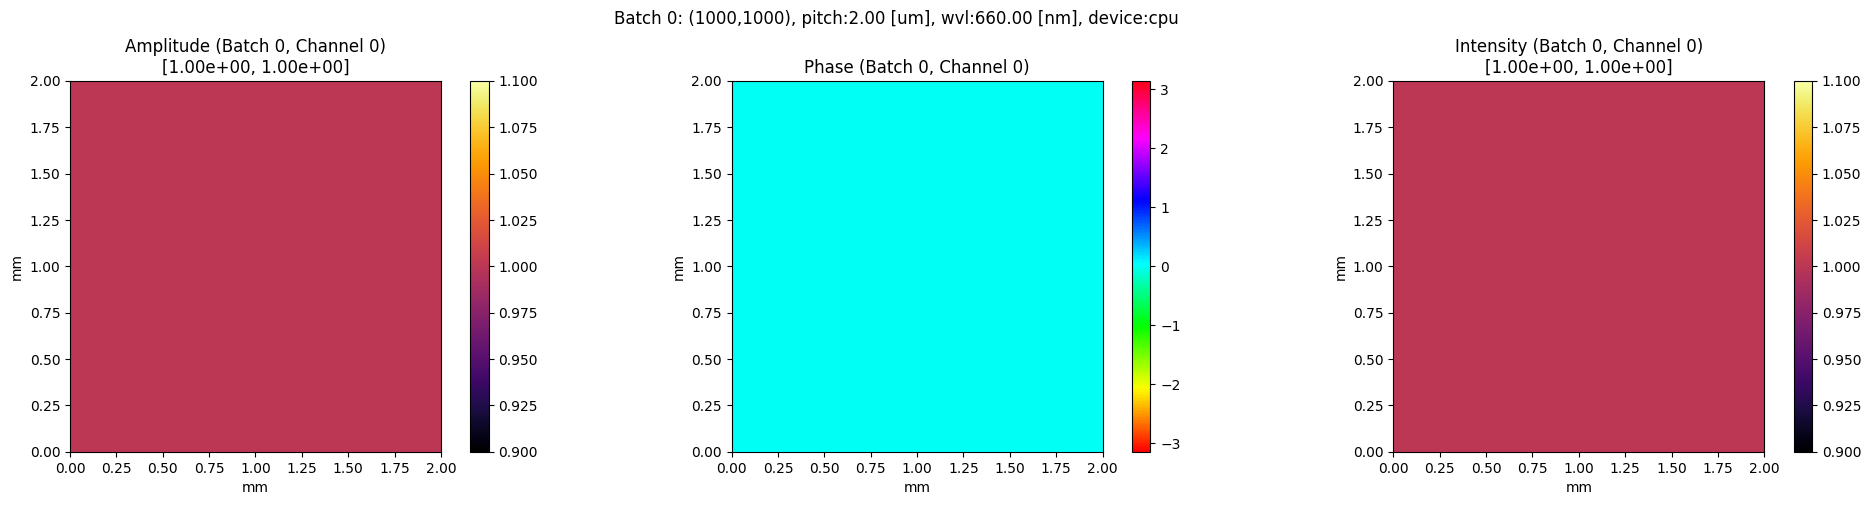

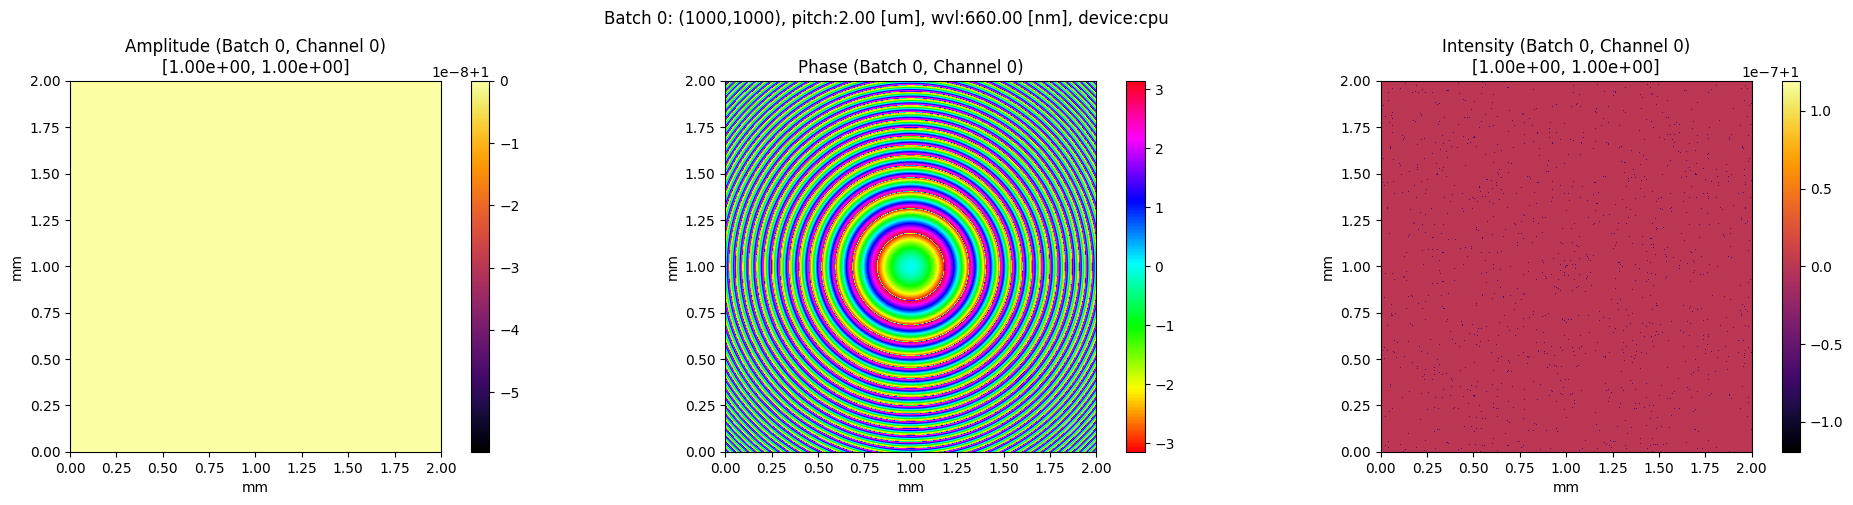

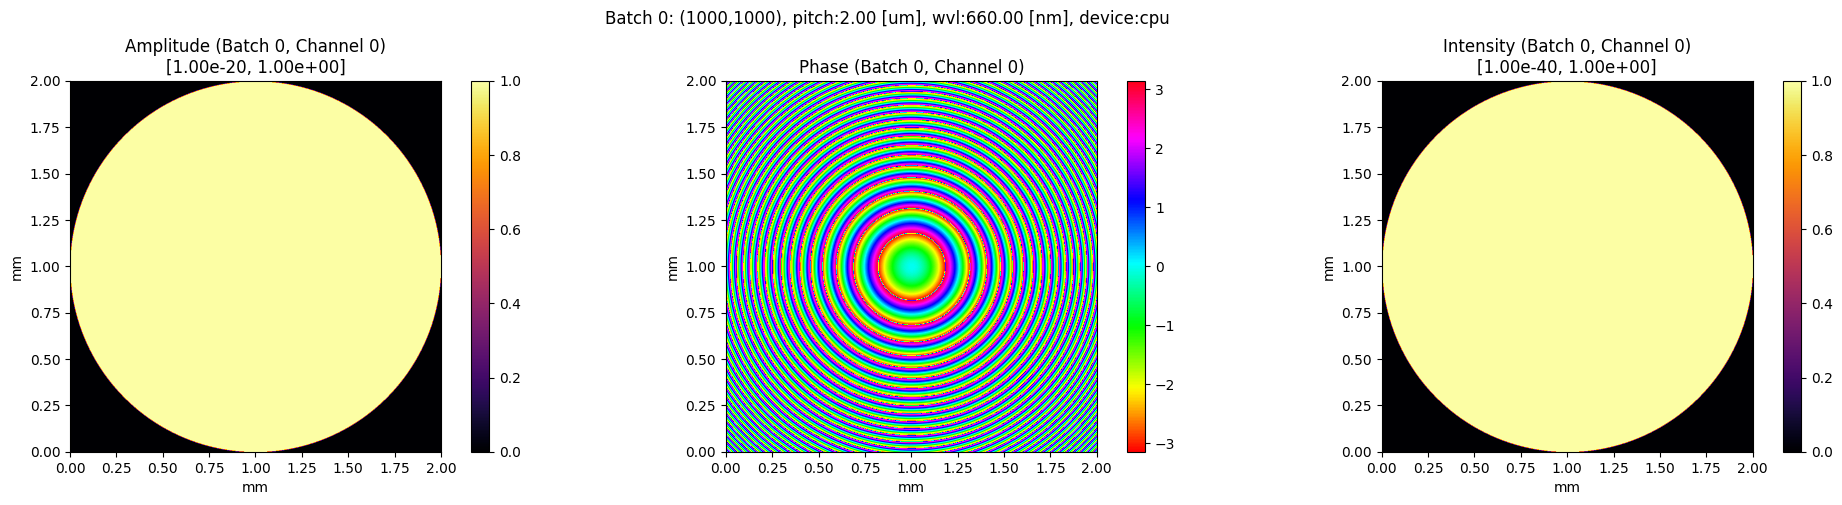

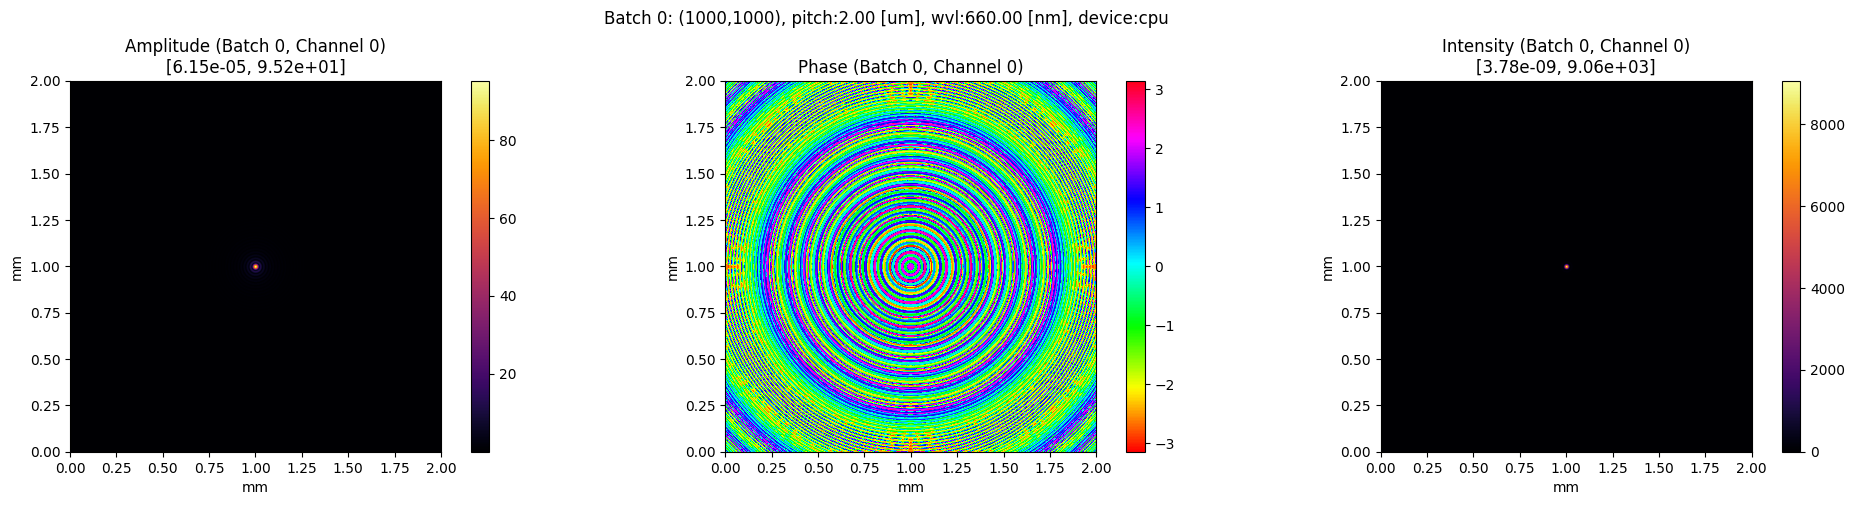

In [8]:
light.visualize()

light_after_lens = lens.forward(light)
light_after_lens.visualize()

light_after_aperture = aperture.forward(light_after_lens)
light_after_aperture.visualize()

light_after_prop = prop.forward(light_after_aperture, f)
light_after_prop.visualize()

## **📸Step 4 : distance varying PSF**
Now we'll explore how the `Point Spread Function (PSF)` changes as the distance between the lens and sensor varies. When the sensor is precisely at the focal distance, the PSF appears as a diffraction-limited focused dot. As we move away from the focal plane, we can observe how the PSF broadens and defocuses, which is critical for understanding depth effects in imaging systems.

Text(0.5, 1.0, 'PSF for the coded-aperture camera')

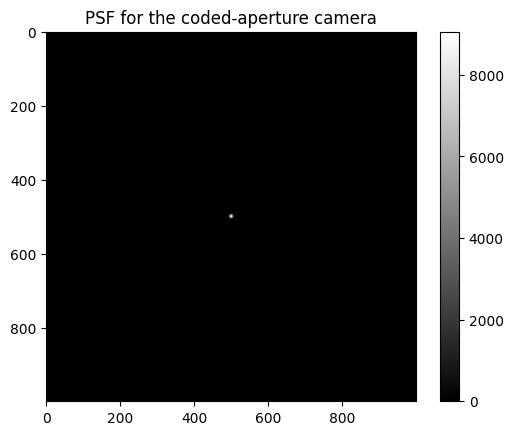

In [9]:
PSF = light_after_prop.get_intensity()

plt.figure()
plt.imshow(PSF.data.cpu().squeeze(), cmap='gray')
plt.colorbar()
plt.title('PSF for the coded-aperture camera')

Now, let's make the rendering pipeline as a function so that we can easily call it later. Here, we parameterize the render function with two input parameters of the distance from the lens to the sensor and the aperture's amplitude change profile.

In [11]:
def render(lens2sensor_d, aperture_amp_modulation):
    light = pado.light.Light(dim,pitch,wvl,device=device)
    light_after_lens = lens.forward(light)
    aperture.set_amplitude_change(aperture_amp_modulation)
    light_after_aperture = aperture.forward(light_after_lens)
    light_after_prop = prop.forward(light_after_aperture, lens2sensor_d)
    PSF = light_after_prop.get_intensity()
    return PSF

Let's see how the PSF change for the varying distance between the lens and the sensor

c:\Users\yilin\pado\pado\propagator.py:460: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z, device=light.device)


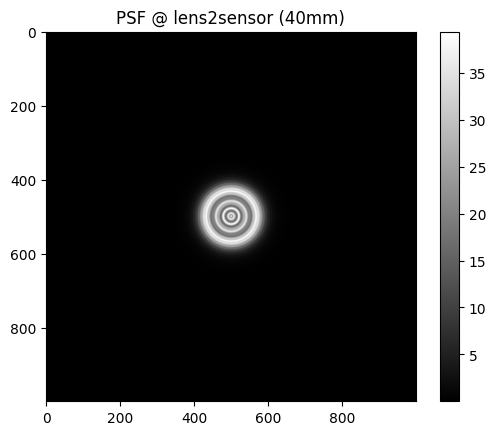

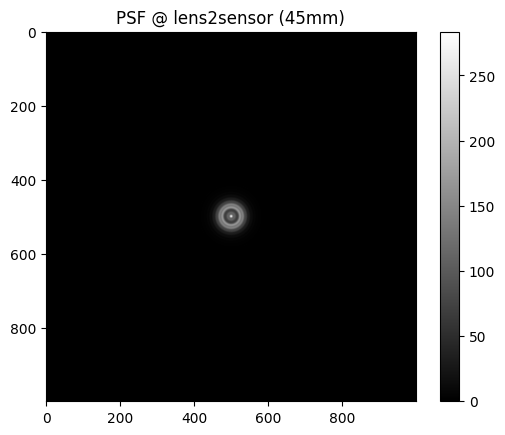

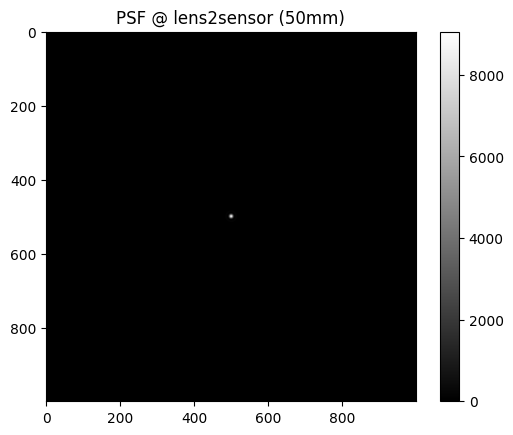

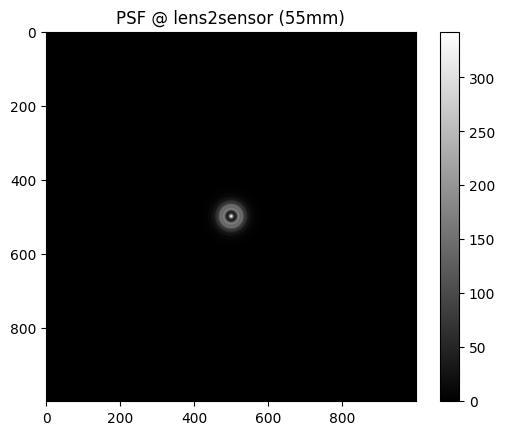

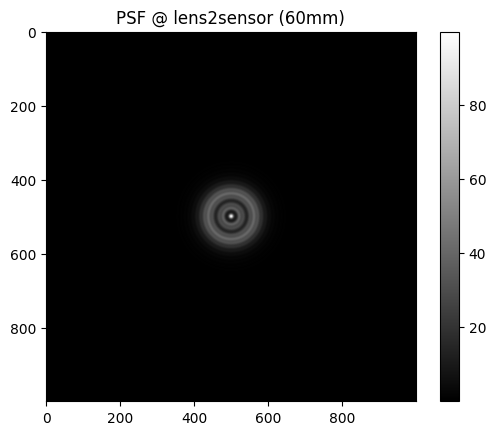

In [12]:
circular_aperture_change = aperture.get_amplitude_change()
for lens2sensor_d in torch.linspace(f-1e-2, f+1e-2, 5):
    PSF = render(lens2sensor_d, circular_aperture_change)

    plt.figure()
    plt.imshow(PSF.data.cpu().squeeze(), cmap='gray')
    plt.title('PSF @ lens2sensor (%2.fmm)'%(lens2sensor_d*1e3))
    plt.colorbar()

## **🔬 Step 5: Coded Aperture Imaging**
Now, let's test a coded-aperture configuration, which introduces a customized pattern to modulate the amplitude of light passing through the aperture. Unlike conventional circular apertures.

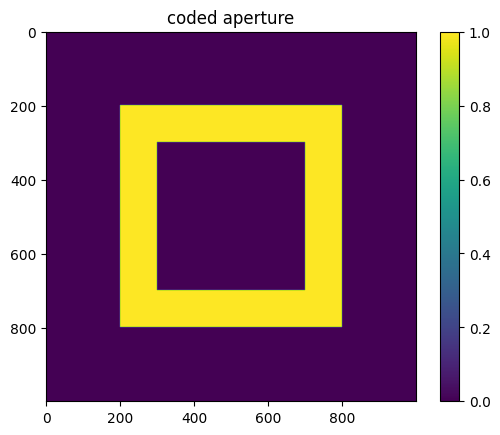

In [14]:
coded_pattern = torch.zeros((1,1,R,C), device=device)
thickness = 50
coded_pattern[0, 0, R//4-thickness:R//4+thickness, C//4-thickness:3*C//4+thickness] = 1
coded_pattern[0, 0, 3*R//4-thickness:3*R//4+thickness, C//4-thickness:3*C//4+thickness] = 1
coded_pattern[0, 0, R//4-thickness:3*R//4+thickness, C//4-thickness:C//4+thickness] = 1
coded_pattern[0, 0, R//4-thickness:3*R//4+thickness, 3*C//4-thickness:3*C//4+thickness] = 1
plt.figure()
plt.imshow(coded_pattern.data.cpu().numpy().squeeze())
plt.title('coded aperture')
plt.colorbar()

Again, we simulate the PSF for the coded-aperture camera

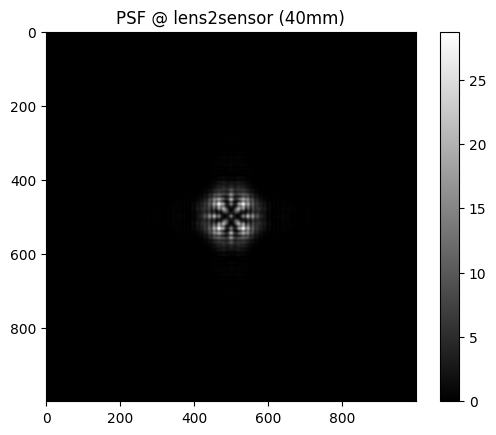

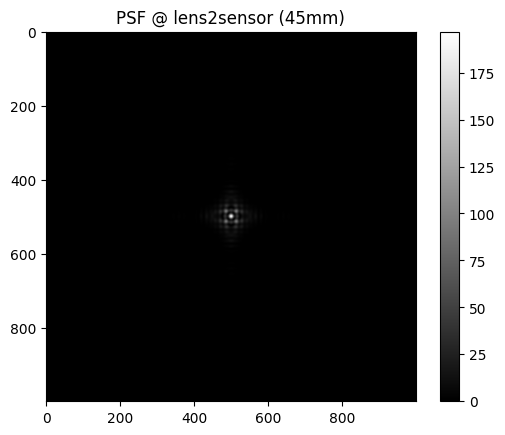

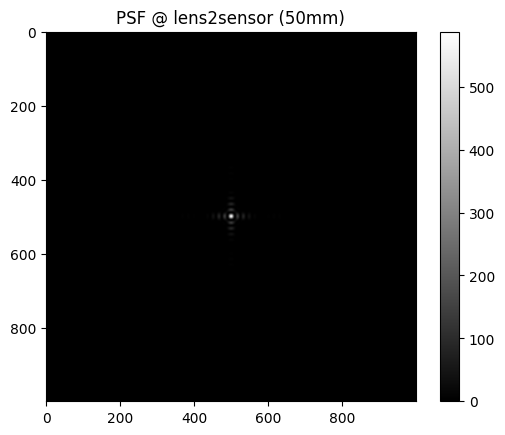

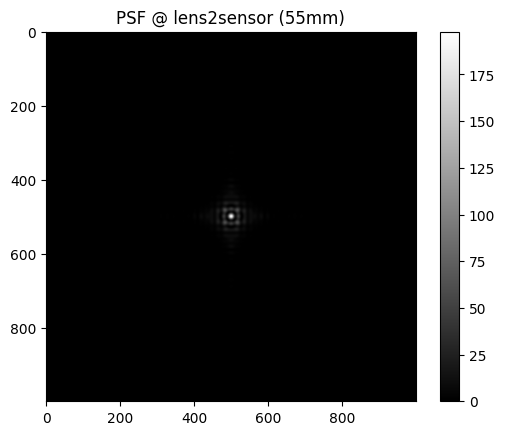

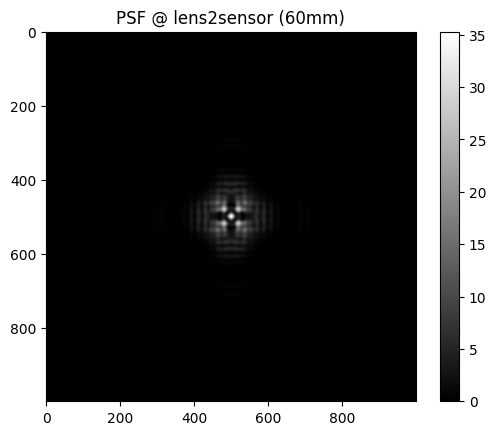

In [15]:
circular_aperture_change = aperture.get_amplitude_change()
for lens2sensor_d in torch.linspace(f-1e-2, f+1e-2, 5):
    PSF = render(lens2sensor_d, coded_pattern)

    plt.figure()
    plt.imshow(PSF.data.cpu().squeeze(), cmap='gray')
    plt.title('PSF @ lens2sensor (%2.fmm)'%(lens2sensor_d*1e3))
    plt.colorbar()